# Question Answering

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):

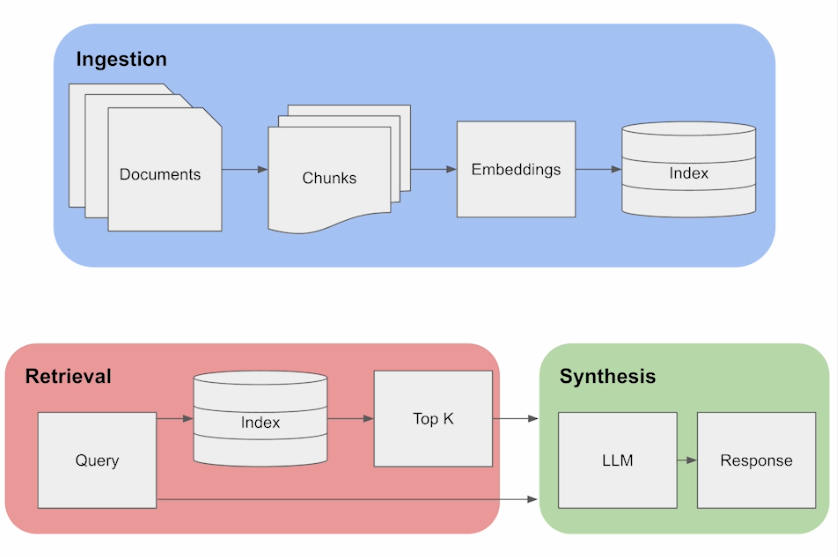

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install qdrant_client langchain_huggingface langchain-community langchain-qdrant pypdf openai langchain transformers langchain_huggingface langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.

In [ ]:
import openai

In [ ]:
openai.api_key = ""
qdrant_url = ""
qdrant_key = ""
collection_name = "ML_Lectures"
llm_name = "gpt-4o-mini"

# 1: Q/A Chain

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
import openai
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter
prompt_str="""
Answer the user question briefly.

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(prompt_str)
question_fetcher=itemgetter("question")
llm = ChatOpenAI(model_name=llm_name, openai_api_key=openai.api_key, temperature=0)

chain = question_fetcher| prompt | llm | StrOutputParser()
query = "tell me about lahore"  # Question here
response = chain.invoke({"question": query})
print(response)

<ipython-input-6-4a1fc6a89975>:14: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name=llm_name, openai_api_key=openai.api_key, temperature=0)


Lahore is the capital city of the Punjab province in Pakistan and is known for its rich history, vibrant culture, and architectural heritage. It is the second-largest city in Pakistan and serves as a major economic, political, and educational center. Notable landmarks include the Lahore Fort, Badshahi Mosque, and the Shalimar Gardens. The city is also famous for its cuisine, festivals, and lively arts scene.


# 2. Q/A Retriever

In [ ]:
from qdrant_client import QdrantClient
from langchain_core.documents import Document
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
import openai
import os
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate



In [ ]:
embed_model = HuggingFaceEmbeddings(model_name='BAAI/bge-small-en-v1.5')

<ipython-input-9-2c465c9fa5b2>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name='BAAI/bge-small-en-v1.5')
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your setti

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
loaders = PyPDFLoader("/content/Dsa.pdf")
pages = loaders.load()

In [ ]:
len(pages)

112

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [ ]:
splits = text_splitter.split_documents(pages)

In [ ]:
len(splits)

161

In [ ]:
qdrant = QdrantVectorStore.from_documents(
    splits,
    embed_model,
    url=qdrant_url,
    prefer_grpc=True,
    api_key=qdrant_key,
    collection_name=collection_name,
)

**chain implementation**

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
prompt_str="""
Answer the user question based only on the following context:
{context}

Question: {question}
"""
_prompt = ChatPromptTemplate.from_template(prompt_str)
num_chunks=3
retriever = qdrant.as_retriever(search_type="similarity",
                                        search_kwargs={"k": num_chunks})
chat_llm = ChatOpenAI(model_name=llm_name, openai_api_key=openai.api_key, temperature=0)
query_fetcher= itemgetter("question")
setup={"question":query_fetcher,"context":query_fetcher | retriever | format_docs}
_chain = (setup |_prompt | chat_llm)


In [ ]:
query="what is DSA?"

In [ ]:
response=_chain.invoke({"question":query})

In [ ]:
response

AIMessage(content='DSA stands for Data Structures and Algorithms. It is an open source project that houses a C# implementation of all the pseudocode listed in the book. The project can be found at http://codeplex.com/dsa.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 825, 'total_tokens': 870, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-8227c4db-0449-4f2c-8cbf-709c2b064b73-0')

In [ ]:
response.content

'DSA stands for Data Structures and Algorithms. It is an open source project that houses a C# implementation of all the pseudocode listed in the book. The project can be found at http://codeplex.com/dsa.'

## Conversational Chain

In [ ]:
history = []

In [ ]:

prompt_str="""
Answer the user question briefly.

Question: {question}

conversation_history: {chat_history}
"""
prompt = ChatPromptTemplate.from_template(prompt_str)
question_fetcher=itemgetter("question")
history_fetcher=itemgetter("chat_history")
llm = ChatOpenAI(model_name=llm_name, openai_api_key=openai.api_key, temperature=0)
setup={"question":question_fetcher,"chat_history":history_fetcher}
chain = setup|prompt | llm | StrOutputParser()
query = "tell me about lahore"
response = chain.invoke({"question": query,"chat_history":"\n".join(str(history))})
print(response)
query="user_question:"+query
response="ai_response:"+response
history.append((query, response))


Lahore is the capital city of the Punjab province in Pakistan and is known for its rich history, vibrant culture, and architectural heritage. It is the second-largest city in Pakistan and serves as a major economic, political, and cultural center. Notable landmarks include the Lahore Fort, Badshahi Mosque, and the Shalimar Gardens. The city is also famous for its cuisine, festivals, and educational institutions.


In [ ]:
history

[('user_question:tell me about lahore',
  'ai_response:Lahore is the capital city of the Punjab province in Pakistan and is known for its rich history, vibrant culture, and architectural heritage. It is the second-largest city in Pakistan and serves as a major economic, political, and cultural center. Notable landmarks include the Lahore Fort, Badshahi Mosque, and the Shalimar Gardens. The city is also famous for its cuisine, festivals, and educational institutions.')]